# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [2]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [3]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

# Image

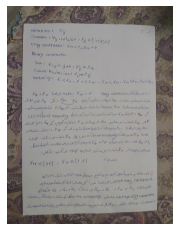

In [4]:
im = cv2.imread('images/example2.jpg')
imshow(im)

# Process

Follow the hints in each section to implement the functions.

# Morphological operation and GrabCut (extera part*)

In [5]:
def blank_page(im):
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5,5),np.uint8)
    img = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel, iterations= 3)

    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (20,20,img.shape[1]-20,img.shape[0]-20)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    return img

True

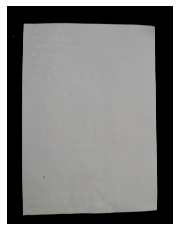

In [6]:
blank = blank_page(im)
imshow(blank)
cv2.imwrite('blank.png', blank)

## Grayscale Transform

Use the `cv2.cvtColor` function with any color space you deem appropriate. The resulting image should have a single channel.

In [7]:
def to_grayscale(im):
    # Your code goes here.
    img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return img

True

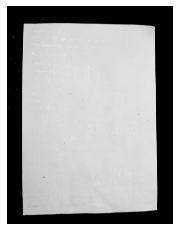

In [8]:
# I changed im to blank
grayscale = to_grayscale(blank)
imshow(grayscale)
cv2.imwrite('grayscale.png', grayscale)

## Blurring the Image

The Gaussian filter or its more advanced sibling, the Bilateral filter, have shown the best results. Go with whatever smoothing filter you prefer. Considering that the image is highly likely to contain texts, adjust your window size accordingly.

In [9]:
def blur(im):
    # Your code goes here.
    img = cv2.bilateralFilter(im, 5, 60, 60)
    return img
#     img = cv2.GaussianBlur(im,(11,11),2)
#     threshold = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#     threshold = cv2.fastNlMeansDenoising(threshold, 11, 31, 11)
#     return threshold

True

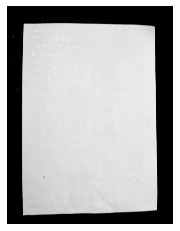

In [10]:
blurred = blur(grayscale)
imshow(blurred)
cv2.imwrite('blurred.png', blurred)

## Edge Detection

The `cv2.Canny` filter tends to generate the best results. Tune its thresholds using the provided image and try it on a few more examples.

In [11]:
def to_edges(im):
    # Your code goes here.
    edges = cv2.Canny(im, 20, 70)
    return edges

True

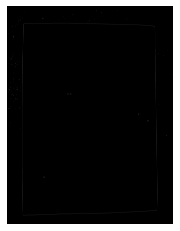

In [12]:
edges = to_edges(blurred)
imshow(edges)
cv2.imwrite('edges.png', edges)

## Contour Detection

We highly suggest that you learn more about [image contours](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html), specifically, the `cv2.findContours` function. You'd want to find the contour that has the largest surface area (using `cv2.contourArea`) and simplify its boundaries to a quadrilateral using `cv2.approxPolyDP` (and possibly `cv2.arcLength`). If this all sounds too complicated, go with the Hough transform. As discussed in the instructions, you can use the Hough transform to identify four lines within the output of `to_edges` to identify the most prominent parallelogram present in the image. This isn't, however, the best solution.

Regardless of the method, the output of the function must be the coordinates of the four vertices containing the page, in the form of a `4x2` array.

*Hint*: If you are using `cv2.findContours`, the Simple Approximation Model suffices for our purposes.

In [13]:
def find_vertices(im):
    # Your code goes here.
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    h = len(im)
    w = len(im[0])
    area = (w - 10) * (h - 10)
    area_found = area * 0.5
    contour = np.array([[1, 1], [1, h-1], [w-1, h-1], [w-1, 1]])
    
    for i in contours:
        perimeter = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.03 * perimeter, True)
        if (len(approx) == 4 and cv2.isContourConvex(approx) and area_found < cv2.contourArea(approx) < area):
            area_found = cv2.contourArea(approx)
            contour = approx
    return contour.reshape((4, 2))

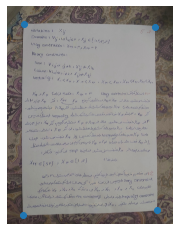

In [14]:
# Let's draw the points on the original image.
imshow(im)
vertices = find_vertices(edges)
plt.scatter([x for x, y in vertices], [y for x, y in vertices])

## Perspective Transform

We can use the `cv2.getPerspectiveTransform` function to find a transform that maps the region we have identified to a rectangle that we can easily crop. You then need to use `cv2.warpPerspective` to apply this transform and crop out the target region.

**Note**: `cv2.getPerspectiveTransform` expects your vertices in a particular order. They should be top left, top right, bottom right, and finally, bottom left. We have implemented a utility function for this purpose.

In [15]:
def crop_out(im, vertices):
    # Your code goes here.
    vertices = reorder(vertices)
    (a, b, c, d) = vertices
    w1 = np.sqrt(((c[0] - d[0]) ** 2) + ((c[1] - d[1]) ** 2))
    w2 = np.sqrt(((b[0] - a[0]) ** 2) + ((b[1] - a[1]) ** 2))
    width = max(int(w1), int(w2))
    h1 = np.sqrt(((b[0] - c[0]) ** 2) + ((b[1] - c[1]) ** 2))
    h2 = np.sqrt(((a[0] - d[0]) ** 2) + ((a[1] - d[1]) ** 2))
    height = max(int(h1), int(h2))
    target = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype = "float32")
    
    transform = cv2.getPerspectiveTransform(vertices, target)  # get the top or bird eye view effect
    return cv2.warpPerspective(im, transform, (width, height))

True

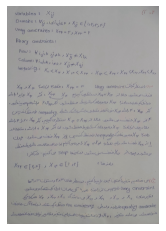

In [16]:
cropped = crop_out(im, vertices)
imshow(cropped)
cv2.imwrite('cropped.png', cropped)

## Image Enhancement

I'll leave this part up to you!

In [17]:
def enhance(im):
    # there are other methods to enhance image in the notebook
    
    # Your code goes here.
    image = im.copy()
    
    # Create our shapening kernel, it must equal to one eventually
    kernel_sharpening = np.array([[0,-1,0], 
                                [-1, 5,-1],
                                [0,-1,0]])
    # applying the sharpening kernel to the input image
    sharpened = cv2.filter2D(image, -1, kernel_sharpening)
    value1, value2 = 30, 25
    hsv = cv2.cvtColor(sharpened, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value1
    v[v > lim] = 255
    v[v <= lim] += value1
    lim = 255 - value2
    s[s > lim] = 255
    s[s <= lim] += value2
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)   

    return img

## Result

Let's put everything together and get the result in one go.

In [18]:
def scan(im):
    
    # I added this line
    blank = blank_page(im)
    
    grayscale = to_grayscale(blank)
    blurred = blur(grayscale)
    edges = to_edges(blurred)
    vertices = find_vertices(edges)
    cropped = crop_out(im, vertices)
    return enhance(cropped)

True

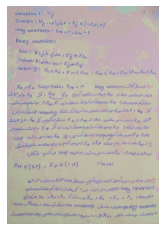

In [19]:
scanned = scan(im)
imshow(scanned)
cv2.imwrite('scanned.png', scanned)

# other methods to enhance cropped image

## cartooning

In [20]:
def cartooning(img_rgb):
    num_down = 2       # number of downsampling steps
    num_bilateral = 7  # number of bilateral filtering steps
    
    # downsample image using Gaussian pyramid
    img_color = img_rgb
    for _ in range(num_down):
        img_color = cv2.pyrDown(img_color)
        
    # repeatedly apply small bilateral filter instead of applying one large filter
    for _ in range(num_bilateral):
        img_color = cv2.bilateralFilter(img_color, d=9,
                                        sigmaColor=9,
                                        sigmaSpace=7)

    # upsample image to original size
    for _ in range(num_down):
        img_color = cv2.pyrUp(img_color)
    img_color = img_color[:img_rgb.shape[0], :img_rgb.shape[1], :img_rgb.shape[2]]

    # convert to grayscale and apply median blur
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.medianBlur(img_gray, 7)

    # detect and enhance edges
    def edge(block,const):
        return cv2.adaptiveThreshold(img_blur, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,blockSize=block,C=const)

   
    img_edge1 = edge(15,3)
    
    # convert back to color, bit-AND with color image
    img_edge1 = cv2.cvtColor(img_edge1, cv2.COLOR_GRAY2RGB)
    img_cartoon1 = cv2.bitwise_and(img_color, img_edge1)

    return img_cartoon1


True

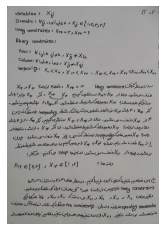

In [21]:
cartoon = cartooning(cropped)
imshow(cartoon)
cv2.imwrite('cartoon.png', cartoon)

## histogram equalization

True

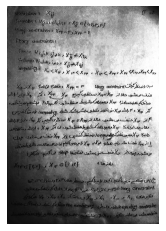

In [22]:
cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
image = cv2.equalizeHist(cropped_gray)
imshow(image)
cv2.imwrite('equalized.png', image)

## thresholding and denoise

In [23]:
cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
ret2,thresh = cv2.threshold(cropped_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
denoised = cv2.fastNlMeansDenoising(thresh, 11, 31, 9)

True

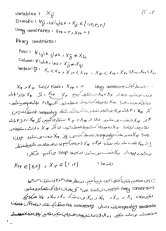

In [24]:
imshow(denoised)
cv2.imwrite('threshold.png', denoised)

## adaptive thresholding and denoise

In [25]:
cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
thresh_adapt = cv2.adaptiveThreshold(cropped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 23, 5)
denoised_adapt = cv2.fastNlMeansDenoising(thresh_adapt, 11, 31, 9)

True

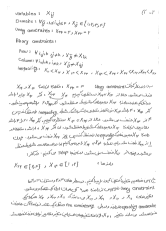

In [26]:
imshow(denoised_adapt)
cv2.imwrite('adaptive_treshold.png', denoised_adapt)

## convert to LAB color space and use CLAHE

In [27]:
def CLAHE(cropped):
    lab= cv2.cvtColor(cropped, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    result = np.hstack((cropped, enhanced_img))
    return result

True

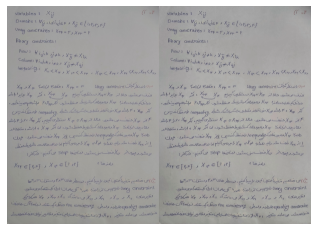

In [28]:
result = CLAHE(cropped)
imshow(result)
cv2.imwrite('clahe.png', result)

## divide by fake flat field F

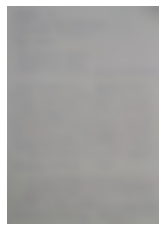

In [29]:
F = cv2.GaussianBlur(cropped, (401, 401), 0)
C = np.int64(np.round((cropped * np.mean(F)) / F))
imshow(F)

True

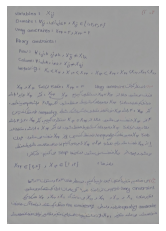

In [30]:
imshow(C)
cv2.imwrite('C.png', C)

## divide by fake flat field F and use CLAHE

True

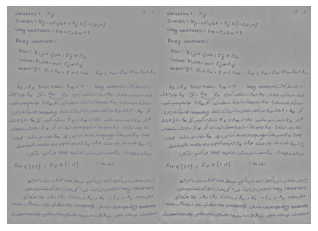

In [31]:
C_uint = C.astype('uint8')
C_C = CLAHE(C_uint)
imshow(C_C)
cv2.imwrite('C_CLAHE.png', C_C)